In [10]:
using Revise
using HypergraphDetectability
using DataFrames
using Clustering
using Statistics
using RCall
using Arpack
using Plots
using LinearAlgebra
using StatsBase
using MultivariateStats
import Random

In [11]:
H, z = HypergraphDetectability.read_hypergraph_data("contact-high-school-classes");

In [21]:
# obtain initial clustering

Random.seed!(51)
nev = 100
ngroups = length(unique(z))
ẑ = rand(1:ngroups, n);

for i ∈ 1:3
    ẑ = HypergraphDetectability.NBSC_round(H, ẑ; nev = nev, ngroups = ngroups)
    print("Adjusted Rand Index to ground truth: ")
    println(randindex(z, ẑ)[1])
end

Adjusted Rand Index to ground truth: 0.7906635693087559
Adjusted Rand Index to ground truth: 0.6767438717748334
Adjusted Rand Index to ground truth: 0.8184661262463966


Now we're going to get some eigenvectors and consensus clustering matrices to look at. 

In [22]:
@time J = reducedBPJacobian(H, ẑ);

 30.728599 seconds (239.81 k allocations: 553.818 MiB, 0.26% gc time)


In [23]:
@time E = Arpack.eigs(J; nev = 200);

 32.565196 seconds (7.37 k allocations: 338.105 MiB, 0.06% gc time)


In [25]:
sum(imag.(E[1]) .≈ 0)

190

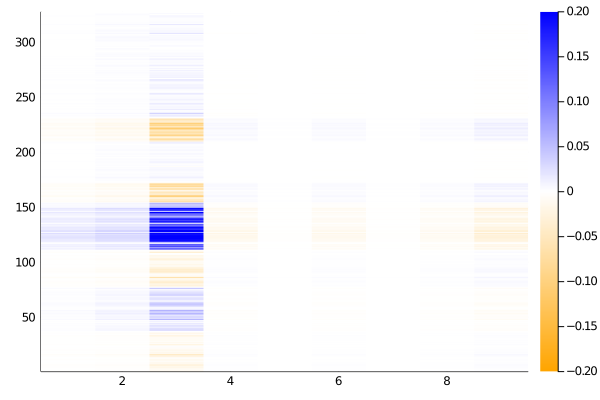

In [124]:
n = length(H.N)
k̄ = length(keys(H.E))
ℓ = ngroups

i = 4
v = E[2][:, i]
U = HypergraphDetectability.transform_eigenvector(v, H);

order = sortperm(ẑ)

heatmap(U[order,:], 
        c = cgrad([:orange, :white, :blue], 
        [-1.0, 0.0, 1.0]), 
    clims=(-.2,.2))

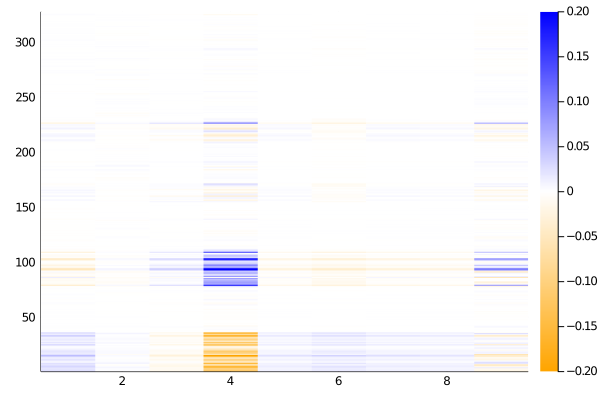

In [133]:
n = length(H.N)
k̄ = length(keys(H.E))
ℓ = ngroups


j = 51
v = E[2][:, j]
V = HypergraphDetectability.transform_eigenvector(v, H);

order = sortperm(ẑ)

heatmap(V[order,:], 
        c = cgrad([:orange, :white, :blue], 
        [-1.0, 0.0, 1.0]), 
    clims=(-.2,.2))

# Consensus Matrix

In [117]:
C = zeros(n, n)

for h ∈ 1:100
    v = E[2][:, h]
    X = HypergraphDetectability.transform_eigenvector(v, H);
    for s ∈ 1:ℓ, i ∈ 1:n, j ∈ 1:n
        C[i,j] += (sign(X[i, s]) == sign(X[j, s]))
    end
end

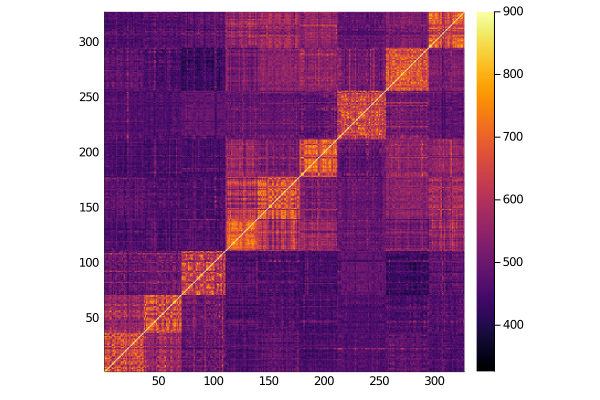

In [120]:
heatmap(C[sortperm(z), sortperm(z)], 
        aspect_ratio=:equal, 
        xlim = (1, n), 
        ylim = (1, n))

# R Visualizations

In [62]:
R"""
library(tidyverse)
"""

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
│ ✔ tibble  3.0.3     ✔ dplyr   1.0.0
│ ✔ tidyr   1.1.0     ✔ stringr 1.4.0
│ ✔ readr   1.3.1     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


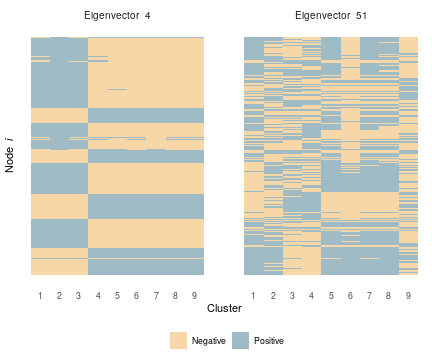

RObject{VecSxp}


In [265]:
R"""

inauguration_2021 <- c("#5445b1", "#749dae", "#f3c483", "#5c1a33", "#cd3341","#f7dc6a")


prep_eigenvector <- function(U, i){
    U %>% 
    as.data.frame() %>% 
    mutate(Node = row_number()) %>% 
    pivot_longer(!Node) %>% 
    mutate(group = as.integer(sub(".", "", name))) %>% 
    select(-name) %>% 
    mutate(value = sign(value)) %>% 
    mutate(value = ifelse(value > 0, "Positive", "Negative")) %>%
    mutate(id = paste("Eigenvector ", i))
}

p <- prep_eigenvector($(U[order,:]), $i) %>% 
    rbind(prep_eigenvector($(V[order,:]), $j)) %>% 
    ggplot() + 
    aes(x = group, y = Node, fill = value) + 
    geom_tile(alpha = 0.7) + 
    facet_wrap(~id) + 
    theme_minimal() + 
    scale_fill_manual(values = c(inauguration_2021[3], inauguration_2021[2])) + 
    theme(strip.background = element_blank(),
          panel.spacing.x = unit(8, "mm"),
          strip.text = element_text(size = 10),
          panel.grid = element_blank(), 
          axis.text.y = element_blank(), 
          legend.position = "bottom") +
    guides(fill = guide_legend(title = element_blank())) +
    ylab(expression(Node~italic(i))) + 
    xlab(expression(Cluster)) + 
    scale_x_continuous(breaks = 1:$ℓ, labels = 1:$ℓ) 

"""

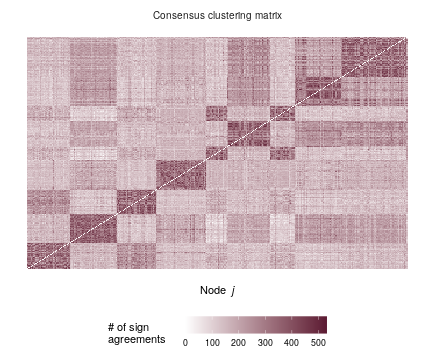

RObject{VecSxp}


In [289]:
R"""
C <- $(C[order, order])

q <- C %>% 
    as.data.frame() %>% 
    mutate(i = row_number()) %>% 
    pivot_longer(!i) %>% 
    mutate(j = as.integer(sub(".", "", name))) %>% 
    mutate(value = ifelse(i == j, NA, value)) %>% 
    mutate(value = value - min(value, na.rm = T)) %>% 
    mutate(value = ifelse(i == j, 0, value)) %>% 
    mutate(title = "Consensus clustering matrix") %>% 
    ggplot() + 
    aes(x = i, y = j, fill = value) + 
    theme_bw() + 
    theme(strip.background = element_blank(),
          panel.spacing.x = unit(8, "mm"),
          strip.text = element_text(size = 10),
          panel.grid = element_blank(),
          panel.border = element_blank(), 
          axis.text = element_blank(), 
          axis.ticks = element_blank(),
          axis.title.y = element_blank(), 
          legend.position = "bottom",
          legend.key.width = unit(1, 'cm')) + 
    geom_tile() + 
    scale_fill_gradient(low = "white", high = inauguration_2021[4]) + 
    facet_wrap(~title) + 
    guides(fill = guide_colorbar(title = "# of sign\nagreements\t")) + 
    xlab(expression(Node~italic(j))) 
"""

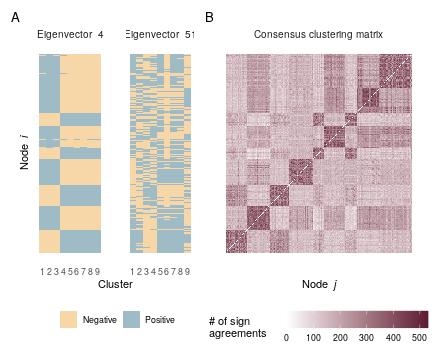

RObject{VecSxp}


In [291]:
R"""
library(patchwork)

s <- (p | q) + plot_layout(widths = c(1, 1.3), heights = c(1.3, 1.3)) + plot_annotation(tag_levels = 'A')

ggsave("fig/consensus-clustering.png", s, width = 8, height = 6, dpi = 600)

s

"""